# Classifying high dimensionality remote sensing images
This notebook demonstrates how to compose a classification algorithm using dynamic raster functions

<h1>**Table of Contents**<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Classifying-high-dimensionality-remote-sensing-images" data-toc-modified-id="Classifying-high-dimensionality-remote-sensing-images-1">Classifying high dimensionality remote sensing images</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#What-are-Hyperspectral-images?" data-toc-modified-id="What-are-Hyperspectral-images?-1.0.1">What are Hyperspectral images?</a></span></li><li><span><a href="#What-is-AVIRIS?" data-toc-modified-id="What-is-AVIRIS?-1.0.2">What is AVIRIS?</a></span></li><li><span><a href="#Get-AVIRIS-band-wavelengths" data-toc-modified-id="Get-AVIRIS-band-wavelengths-1.0.3">Get AVIRIS band wavelengths</a></span></li></ul></li><li><span><a href="#Get-spectral-signature-from-the-remotely-sensed-image" data-toc-modified-id="Get-spectral-signature-from-the-remotely-sensed-image-1.1">Get spectral signature from the remotely sensed image</a></span></li><li><span><a href="#Calculate-spectral-angles" data-toc-modified-id="Calculate-spectral-angles-1.2">Calculate spectral angles</a></span></li><li><span><a href="#Create-a-classification-raster-function" data-toc-modified-id="Create-a-classification-raster-function-1.3">Create a classification raster function</a></span><ul class="toc-item"><li><span><a href="#Trying-to-classify-3-different-spectra" data-toc-modified-id="Trying-to-classify-3-different-spectra-1.3.1">Trying to classify 3 different spectra</a></span></li></ul></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.4">Conclusion</a></span></li></ul></li></ul></div>

### What are Hyperspectral images?

A regular color image contains 3 channels - Red, Green, Blue - covering the spectrum of wavelengths that is visible to human eye. While each of these channels record brightness data in grayscale, when viewed stacked on top of one another, they appear to be colored. Remote sensing cameras on high spatial resolution satellites such as [Quickbird](https://g.co/kgs/j11zYT), [Sentinel 2](https://g.co/kgs/JqYZh7) capture in reflected energy in visible and near infrared bands.

![](https://upload.wikimedia.org/wikipedia/commons/4/48/HyperspectralCube.jpg)
<center>A hyperspectral data cube.</center><center>Data is collected in hundreds of narrow bands covering visible, near infrared and mid-far infrared region</center>

In typical remote sensing, satellites use imaging sensors that capture signals from ground (reflected Elecrto Magnetic Radiation) in visible and near-infrared spectrums. This typically produces a 4 - 16 band image depending on the sensor.

Hyperspectral remote sensing uses advanced sensors that finely split this spectrum into hundreds of channels using a diffraction grating and image them. Thus, a hyperspectral scene contains hundreds of contiguous bands for the same study area. The data can be imagined as multiple such bands stacked up by wavelength to produce a cube as shown above.

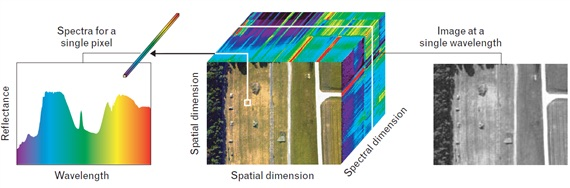

<center><p style="font-size:10px;">https://www.tankonyvtar.hu/en/tartalom/tamop425/0032_terinformatika/ch04s04.html</p></center>
In the graphic above, a hyperspectral **cube** is constructed by stacking the images in adjacent bands. Such visualizations help understand how different features reflect in different bands.

By inquiring the radiance for each pixel, we can construct the reflectance spectra of that pixel (or material in the pixel) across different wavelengths. By analyzing this multi-dimensional data cube as a series of spectral signatures, we can identify the materials present in the cube.

In this sample, we develop an algorithm that can be used to identify such samples.

In [46]:
from arcgis.gis import GIS
from arcgis import raster

import numpy as np
import pandas as pd

from bokeh.io import show, output_notebook, push_notebook
from bokeh.plotting import figure
from IPython.display import clear_output
output_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

Loading BokehJS ...

In [47]:
gis = GIS("https://pythonapi.playground.esri.com/portal","arcgis_python","amazing_arcgis_123")

In [48]:
aviris_item = gis.content.search('AVIRIS', item_type='Imagery Layer')[0]
aviris_item

<Item title:"omaha_aviris" type:Imagery Layer owner:api_data_owner>

### What is AVIRIS?
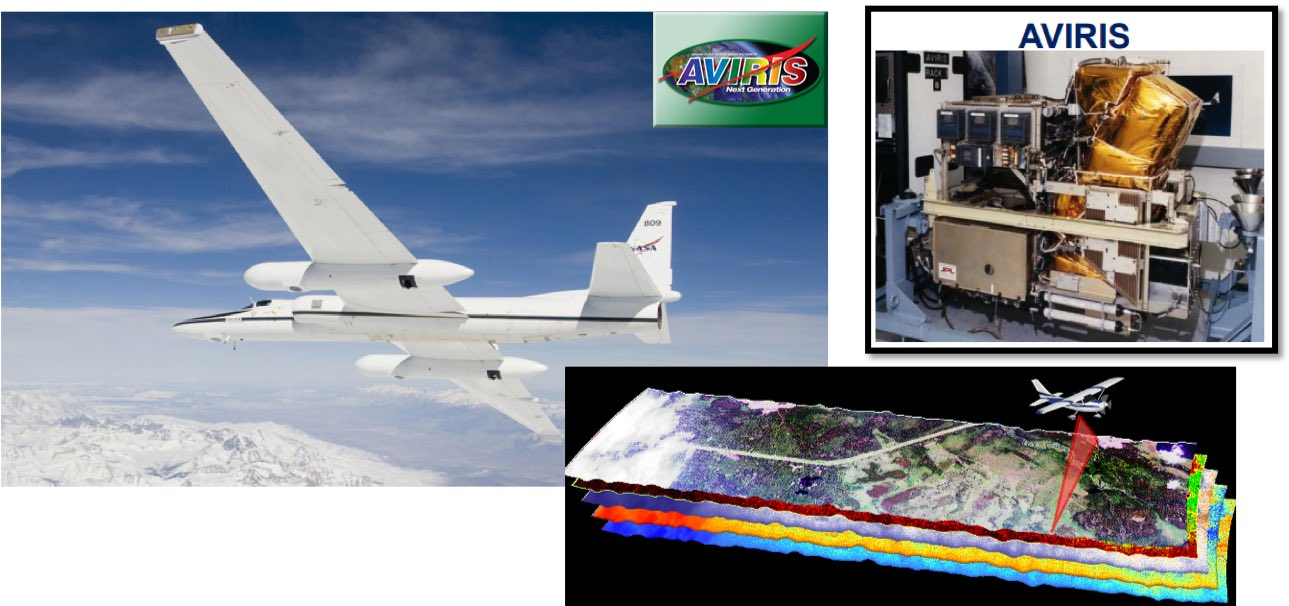

AVIRIS stands for Advanced Visible Infrared Imaging Spectrometer. This is a hyperspectral camera mounted on a high altitude airborne platform. AVIRIS is developed and managed by JPL for NASA.

AVIRIS captures images in `224` bands ranging from `365`nm to `2500` nanometers in the mid infrared region.


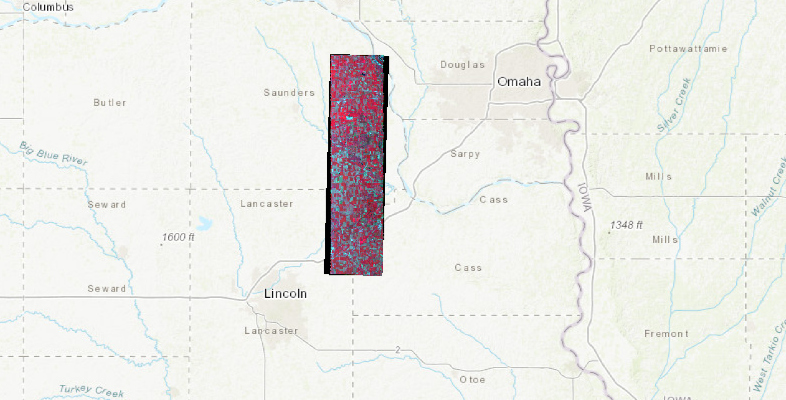

In [12]:
map1 = gis.map('Omaha, NE')
map1

In [5]:
map1.add_layer(aviris_item)

### Get AVIRIS band wavelengths

In [49]:
aviris_layer = aviris_item.layers[0]
aviris_bands = aviris_layer.key_properties()['BandProperties']
len(aviris_bands)

224

In [57]:
aviris_band_df = pd.DataFrame(aviris_bands)
aviris_band_df.head(5)

,HAS_TABLE,KIND,SourceBandIndex,WavelengthMax,WavelengthMin,wavelength
0,0,BAND,0,365.9298,365.9298,365.9298
1,0,BAND,1,375.5940,375.5940,375.5940
2,0,BAND,2,385.2625,385.2625,385.2625
3,0,BAND,3,394.9355,394.9355,394.9355
4,0,BAND,4,404.6129,404.6129,404.6129


In [58]:
aviris_band_df.tail(5)

,HAS_TABLE,KIND,SourceBandIndex,WavelengthMax,WavelengthMin,wavelength
219,0,BAND,219,2457.348,2457.348,2457.348
220,0,BAND,220,2467.273,2467.273,2467.273
221,0,BAND,221,2477.196,2477.196,2477.196
222,0,BAND,222,2487.117,2487.117,2487.117
223,0,BAND,223,2497.036,2497.036,2497.036


## Get spectral signature from the remotely sensed image

In [59]:
aviris_fcc = raster.stretch(raster = raster.extract_band(aviris_layer, 
                                                         band_wavelengths=[831, 665.0994, 560]),
                            stretch_type='histogram')


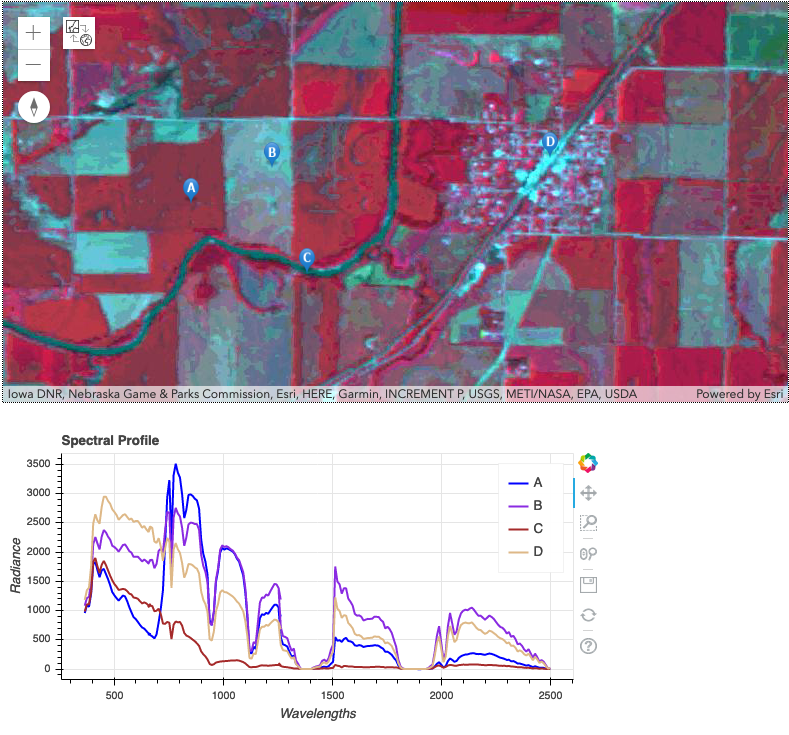

In [26]:
from ipywidgets import Output
from IPython.display import display

map2 = gis.map('Greenwood, NE', zoomlevel=13)
display(map2)

In [52]:
noisy_wavelengths = [43, 60,61] + list(range(78,84)) + \
                    list(range(96,122)) + list(range(151,172))
from pprint import pprint
pprint(noisy_wavelengths, compact=True)

[43, 60, 61, 78, 79, 80, 81, 82, 83, 96, 97, 98, 99, 100, 101, 102, 103, 104,
 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
 121, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165,
 166, 167, 168, 169, 170, 171]


In [53]:
map2.add_layer(aviris_fcc)
out = Output()

The curve above is produced by plotting the pixel values across each band. As discussed earlier, each band here represents the reflected energy in a particular wavelength. Thus, we are able to appreciate how different surface types reflect different amounts of light in different parts of the EMR spectrum. 

Healthy vegetation reflects in green, absorbs in red, blue. It reflects my high in near infrared (around `700` nm) which is why False Color Composites (FCC) images typically use NIR band to show vegetation. Water absorbs across all wavelengths, opposite of urband and built-up area which reflects highly across the spectrum.

##### drawing logic

In [54]:
symbol_list = [{"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/greenA.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/greenB.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueC.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueD.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueE.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueF.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueG.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueH.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueI.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueJ.png","contentType":"image/png","width":14,"height":22},
              {"angle":0,"xoffset":0,"yoffset":8.15625,"type":"esriPMS","url":"http://static.arcgis.com/images/Symbols/AtoZ/blueK.png","contentType":"image/png","width":14,"height":22}]
legend_list = ['A','B','C','D','E','F','G','H','I','J']
bokeh_colors=['blue','blueviolet','brown',
              'burlywood','cadetblue','chartreuse',
              'chocolate','coral','cornflowerblue',
             'cyan','darkblue']
x_axis = [float(s['wavelength']) for s in aviris_bands]

In [55]:
i = 0
p = figure(title="Spectral Profile", x_axis_label='Wavelengths', 
           y_axis_label='Radiance', width=600, height=300)

points_drawn_record = []
points_radiance_record = []
import time
def plot_reflectance_curves(map_handle, clicked_point):
    global i, p
    if i>0:  # for 2nd run and up
        clear_output()  # clear previous output
        display(map2)  # redraw map
        time.sleep(2)
        for pts in points_drawn_record:
            map_handle.draw(pts['clicked_point'], symbol=pts['symbol'])

    # Get cell value from imagery layer
    image_data = aviris_layer.get_samples(clicked_point)
    radiance_values = image_data[0]['values']
    points_radiance_record.append(radiance_values)

    # choose symbol
    map_handle.draw(clicked_point, symbol = symbol_list[i])
    points_drawn_record.append({'clicked_point':clicked_point,
                               'symbol': symbol_list[i]})
        
    lines = p.line(x_axis, radiance_values, 
                   legend=legend_list[i], 
                   line_color=bokeh_colors[i], line_width=2)
    curve_handle = show(p, notebook_handle=True)
    i = i+1
    
map2.on_click(plot_reflectance_curves)

## Calculate spectral angles

We use an algorithm called **Spectral Angle Mapper** (SAM) to find similarity between spectra. In simple terms, this algorithm uses the angluar deviation between two spectra to identify pixels that are spectrally similar. It is represented using the formula

$$
\alpha = cos^{-1}\Bigg[{\frac{\sum_i^k t_i r_i}{\sqrt{\sum_i^k {t_i}^2}\sqrt{\sum_i^k {r_i}^2}}}\Bigg]
$$

where $\alpha$ is the angle in radians between the two spectra across $k$ bands. $t$ and $r$ represent the target and reference spectra. Thus a smaller value of $\alpha$ indicates a higher similarity between two spectra and vice versa.

The SAM algorithm is essentially a **shape similarity** algorithm, where it discounts any differences between spectral amplitude and only takes into account the shape of the spectral curve. This makes it highly suitable to compare the spectral signatures obtained from different platforms (even ground vs aerial / spaceborne platforms) and across different illumination conditions.

In [60]:
def calculate_spectral_angle(reference_spectra, target_spectra):
    ref_arr = np.array(reference_spectra)
    target_arr = np.array(target_spectra)

    numerator = ref_arr.dot(target_arr)
    denominator = np.sqrt(ref_arr.dot(ref_arr)) * np.sqrt(target_arr.dot(target_arr))
    
    alpha = np.arccos(numerator/denominator)  # in radians
    
    return alpha

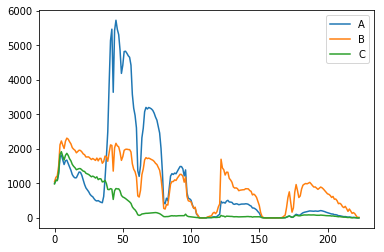

In [61]:
plt.plot(points_radiance_record[0], label='A')
plt.plot(points_radiance_record[1], label='B')
plt.plot(points_radiance_record[2], label='C')
plt.legend()

In [62]:
# between A&B
calculate_spectral_angle(points_radiance_record[0], points_radiance_record[1])

0.628275670887253

In [63]:
# between B&C
calculate_spectral_angle(points_radiance_record[1], points_radiance_record[2])

0.6294860012295236

In [64]:
# between A&C
calculate_spectral_angle(points_radiance_record[0], points_radiance_record[2])

0.9869362732401956

In [65]:
# between A&A
calculate_spectral_angle(points_radiance_record[0], points_radiance_record[0])

/Users/atma6951/anaconda3/envs/geosaurus_gold/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in arccos
  


nan

## Create a classification raster function

In [66]:
from arcgis.raster.functions import band_arithmetic, sqrt, times, divide
from arcgis.raster.functions import acos, stretch, colormap, composite_band
def calculate_spectral_angle_rf_few(reference_spectra, input_layer):
    
    # compose numerator band arithmetic
    index=1
    reference_spectra_denoised = []
    for e in reference_spectra:
        if index in noisy_wavelengths:
            index+=1
            continue
        if index==1:
            numerator_str = f"(B{index} * {e})"
        else:
            numerator_str = numerator_str + f" + (B{index} * {e})"
        index+=1
        reference_spectra_denoised.append(e)
    
    # convert denoised reference spectra to numpy array
    ref_arr = np.array(reference_spectra_denoised)
    #print(len(reference_spectra_denoised))
    
    ## apply band arithmetic
    #print(numerator_str)
    numerator_raster = band_arithmetic(input_layer, numerator_str, astype='F8')
    
    # calculate denominator arithmetic
    denominator_a_constant = np.sqrt(ref_arr.dot(ref_arr))
    #print(denominator_a_constant)
    
    ## compose denominator arithmetic str
    index=1
    for e in reference_spectra:
        if index in noisy_wavelengths:
            index+=1
            continue
        if index==1:
            denominator_str = f"(B{index} * B{index})"
        else:
            denominator_str = denominator_str + f" + (B{index} * B{index})"
        index+=1
    #print(denominator_str)
    
    denominator_b_raster = sqrt([band_arithmetic(input_layer, denominator_str, astype='F8')], astype='F8')
    denominator_raster = times([denominator_b_raster, denominator_a_constant], astype='F8')
    
    # calculate alpha angle
    div_raster = divide([numerator_raster, denominator_raster], astype='F8')
    alpha_raster = acos([div_raster], astype='F8')
    alpha_invert = 1-alpha_raster

    return alpha_invert

In [67]:
reference_spectra = points_radiance_record[0]
alpha_raster_few = calculate_spectral_angle_rf_few(reference_spectra, aviris_layer)

In [68]:
map5 = gis.map('Greenwood, NE', zoomlevel=13)
map5

MapView(layout=Layout(height='400px', width='100%'), zoom=13.0)

In [ ]:
map5.remove_layers()

In [69]:
alpha_few_stretch = stretch(alpha_raster_few, 
                            stretch_type='Histogram', dra=True)
# alpha_few_colormap = colormap(alpha_few_stretch, colorramp='White to Black')
map5.add_layer(alpha_few_stretch)

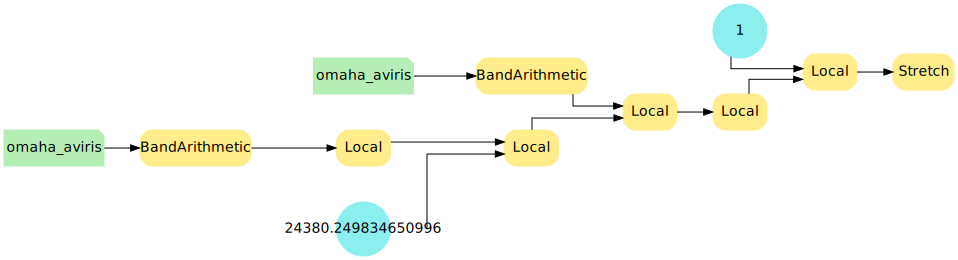

In [70]:
result = alpha_few_stretch.draw_graph()
result

In [ ]:
alpha_few_colormap.export_image(bbox=map5.extent, 
                          image_sr=map5.extent['spatialReference'],
                          bbox_sr=3857,f='image', export_format='jpg',
                         save_file='alpha_few_invert.jpg', save_folder='.')

### Trying to classify 3 different spectra

In [71]:
ref_spectra_a = points_radiance_record[0] #farmland
ref_spectra_b = points_radiance_record[1] #barren land
ref_spectra_c = points_radiance_record[2] #stream water

alpha_a = calculate_spectral_angle_rf_few(ref_spectra_a, aviris_layer)
alpha_b = calculate_spectral_angle_rf_few(ref_spectra_b, aviris_layer)
alpha_c = calculate_spectral_angle_rf_few(ref_spectra_c, aviris_layer)

alpha_composite = composite_band([alpha_a, alpha_b, alpha_c])
alpha_class_stretched = stretch(alpha_composite, stretch_type='Histogram', dra=True)

In [ ]:
from ipywidgets import HBox, Layout
map_a = gis.map('Greenwood, NE', zoomlevel=13)
map_a.add_layer(stretch(alpha_a, stretch_type='Sigmoid', dra=True))
map_b = gis.map('Greenwood, NE', zoomlevel=13)
map_b.add_layer(stretch(alpha_b, stretch_type='Sigmoid', dra=True))
map_c = gis.map('Greenwood, NE', zoomlevel=13)
map_c.add_layer(stretch(alpha_c, stretch_type='Sigmoid', dra=True))

map_a.layout=Layout(flex='1 1', padding='10px',height='500px')
map_b.layout=Layout(flex='1 1', padding='10px',height='500px')
map_c.layout=Layout(flex='1 1', padding='10px',height='500px')
classifier_box = HBox([map_a, map_b, map_c])
classifier_box

![](./alpha_map_2.jpg)

## Conclusion
In this notebook we understood what hyperspectral images are, how to visualize them and how to explore the reflectance spectrum using Python API.

We also built a custom raster function chain to analyze the high dimensional hyperspectral scene and classify it with given spectra.